<a href="https://colab.research.google.com/github/Ssurf777/VAEforPointCloud/blob/main/main_for_PointNetDPF_v2(CD).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

| Feature                         | PointNet Encoder                                            | Induced Set Attention Block (ISAB)                             |
|---------------------------------|-------------------------------------------------------------|-----------------------------------------------------------------|
| **Core Components**             | Pointwise (1D) Convolutions + Max Pooling                   | Multi-head Attention with Inducing Points                       |
| **Permutation Invariance**      | Achieved by Global Max Pooling                              | Achieved by Attention mechanism (order-independent)             |
| **Modeling Point Interactions** | Does **NOT** explicitly model point interactions (points processed independently) | **Explicitly models interactions** between points via Attention |
| **Hierarchical Information**    | Limited (Single-layer aggregation)                          | Capable of capturing **hierarchical structures** via two-step Attention |
| **Information Loss**            | High (Due to simple aggregation by max-pooling)             | Lower (Attention preserves detailed relationships)              |
| **Scalability & Efficiency**    | Very efficient and scalable                                 | Efficient with inducing points, though slightly more complex computationally |
| **Representation Richness**     | Limited (individual points aggregated simply)               | High (multiple attention heads capture diverse relations)       |
| **Impact on VAE Reconstruction Error** | Potentially higher (due to limited interaction modeling) | **Potentially lower** (due to capturing detailed structures)    |


https://www.hello-statisticians.com/ml/deeplearning/set_transformer1.html

In [1]:
!pip install POT

In [2]:
import requests
import os

def download_file(url, local_filename):
    """Downloads a file from a URL to a local file."""
    print(f"Downloading {url}...")
    try:
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(local_filename, 'wb') as f:
                for chunk in r.iter_content(chunk_size=4096):  # Smaller chunk size
                    f.write(chunk)
        print(f"{local_filename} downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Failed to download {local_filename}: {e}")

# URLs for downloading
urls = {
    "utils.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/utils.py",
    "file_io.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/file_io.py",
    "point_cloud.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/point_cloud.py",
    "sampling.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/sampling.py",
    "PointNet_DPF_Model.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/PointNet_DPF_Model.py",
    "ISAB.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/ISAB.py",
    "ChamferDis.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/ChamferDis.py",
    "EarthMoversDis.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/EarthMoversDis.py",
    "train.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/train.py",
    "visualize_loss.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/visualize_loss.py",
    "Dataloader.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/Dataloader.py",
}

# Download each file
for local_filename, url in urls.items():
    download_file(url, local_filename)



utils.py downloaded successfully.
file_io.py downloaded successfully.
point_cloud.py downloaded successfully.
sampling.py downloaded successfully.
PointNet_DPF_Model.py downloaded successfully.
ISAB.py downloaded successfully.
ChamferDis.py downloaded successfully.
EarthMoversDis.py downloaded successfully.
train.py downloaded successfully.
visualize_loss.py downloaded successfully.
Dataloader.py downloaded successfully.


In [3]:

# Import downloaded modules
import utils
import file_io
import point_cloud
import sampling
import PointNet_DPF_Model
import ISAB
import ChamferDis
import EarthMoversDis
import train
import Dataloader
import visualize_loss
from utils import get_available_memory
from file_io import read_off
from point_cloud import pcshow
from sampling import PointSampler
from PointNet_DPF_Model import PointNet_DPF_Model
from ISAB import MultiheadAttentionBlock
from ChamferDis import chamfer_distance
from EarthMoversDis import emd_distance
from train import train
from visualize_loss import visualize_loss
from Dataloader import prepare_data_for_ISAB

available_memory_gb = get_available_memory()
print(f"Available memory: {available_memory_gb:.2f} GB")

Available memory: 50.60 GB


In [4]:
import torch
import torch.optim as optim
import numpy as np
import torch.nn.functional as F



device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_points =2500
# データ準備
file_names = [f"/content/drive/MyDrive/chair/chair_{i:04d}.off" for i in range(1, 10)]
data_loader = prepare_data_for_ISAB(file_names, num_points=num_points, device=device)
print(len(data_loader))
# Flow model num_flow=3, the number of points=2500,
vae = PointNet_DPF_Model(input_dim=3, latent_dim=128, num_points=num_points, num_bins=64, num_flows=3).to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.5e-3)

9


In [5]:
epochs = 2000
interval = 100
rec_error_record = []
z_list = []

for epoch in range(epochs):
    vae.train()
    running_rec_loss = 0.0

    for batch_idx, (x,) in enumerate(data_loader):
        x = x.permute(0, 2, 1).to(device)  # x: [B, 3, N]
        x_input = x                       # 入力用 (B, 3, N)
        x_target = x.permute(0, 2, 1)     # 教師用 (B, N, 3)

        # 1) 順伝播
        x_recon = vae(x_input)  # (B, M, 3)

        # 2) Chamfer距離を損失として計算
        loss = chamfer_distance(x_recon, x_target)

        # 3) 逆伝播と更新
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_rec_loss += loss.item()

        if epoch == epochs - 1:
            z = vae.encoder(x_input)  # 最終エポック時に z を保存
            z_list.append(z.cpu().detach().numpy())

    num_batches = batch_idx + 1
    epoch_rec_loss = running_rec_loss / num_batches
    rec_error_record.append(epoch_rec_loss)

    if epoch % interval == 0:
        print(f"[Epoch {epoch}/{epochs}] Chamfer Loss: {epoch_rec_loss}")

# 学習終了後、z_list 保存
if len(z_list) > 0:
    z_array = np.array(z_list)
    np.save("z_list_final.npy", z_array)
    print(f"z_list saved with shape: {z_array.shape}")
else:
    print("Warning: z_list is empty. Nothing was saved.")


[Epoch 0/2000] Chamfer Loss: 1.0012129412757025
[Epoch 100/2000] Chamfer Loss: 0.11626952472660276
[Epoch 200/2000] Chamfer Loss: 0.08237932291295794
[Epoch 300/2000] Chamfer Loss: 0.06743905279371473
[Epoch 400/2000] Chamfer Loss: 0.05930717744761043
[Epoch 500/2000] Chamfer Loss: 0.052441167955597244
[Epoch 600/2000] Chamfer Loss: 0.047456922423508435
[Epoch 700/2000] Chamfer Loss: 0.04322064978380998
[Epoch 800/2000] Chamfer Loss: 0.03861058524085416
[Epoch 900/2000] Chamfer Loss: 0.04026547591719362
[Epoch 1000/2000] Chamfer Loss: 0.03324464066988892
[Epoch 1100/2000] Chamfer Loss: 0.03057898249891069
[Epoch 1200/2000] Chamfer Loss: 0.027948542808492977
[Epoch 1300/2000] Chamfer Loss: 0.026565606602364115
[Epoch 1400/2000] Chamfer Loss: 0.026132645706335705
[Epoch 1500/2000] Chamfer Loss: 0.025392878179748852
[Epoch 1600/2000] Chamfer Loss: 0.02662819292810228
[Epoch 1700/2000] Chamfer Loss: 0.024356016268332798
[Epoch 1800/2000] Chamfer Loss: 0.024170915078785684
[Epoch 1900/2000]

In [ ]:
# 損失の可視化
#isualize_loss(rec_error_record, reg_error_record, total_error_record)

# モデル保存
#torch.save(vae.state_dict(), '/content/drive/MyDrive/chair/PointNetDPF_Np5000_CD_0330.pth')
print("Model weights have been saved!")

Model weights have been saved!


In [6]:
print(z_list) # z mu logvar

[array([[ 1.35928392e-04, -3.17077748e-02, -1.19425096e-02,
         1.48215398e-01, -1.47748254e-02, -1.11213990e-01,
         1.05042741e-01, -6.15760982e-02,  5.37833869e-02,
        -2.26154849e-02,  3.32489312e-02, -3.19519565e-02,
        -6.18499890e-02, -3.90483439e-03,  1.60249602e-02,
         6.46319240e-02, -3.16157155e-02, -2.47602575e-02,
        -1.45018455e-02, -1.31579023e-02, -1.93321500e-02,
        -2.44010054e-02, -3.26639637e-02, -2.96977852e-02,
        -1.18960869e-02,  1.51222851e-02, -5.41787073e-02,
        -3.35445292e-02, -4.12656665e-02, -2.02927142e-02,
         1.47242658e-02, -4.12154719e-02, -3.87342125e-02,
        -4.98310067e-02, -2.57297121e-02, -2.35483311e-02,
        -6.80468976e-03,  5.87570444e-02, -4.86880839e-02,
        -1.43141504e-02, -2.72975862e-03,  2.10900247e-01,
        -5.22432476e-03, -6.34646043e-03, -3.51137221e-02,
        -4.50449139e-02, -2.61948407e-01, -3.82990018e-02,
        -3.63789126e-02, -7.72505254e-03,  5.40500134e-

# 再構成形状の可視化

torch.Size([1, 2500, 3])
torch.Size([1, 2500, 3])
torch.Size([1, 2500, 3])
torch.Size([1, 2500, 3])
torch.Size([1, 2500, 3])
torch.Size([1, 2500, 3])
torch.Size([1, 2500, 3])
torch.Size([1, 2500, 3])
torch.Size([1, 2500, 3])


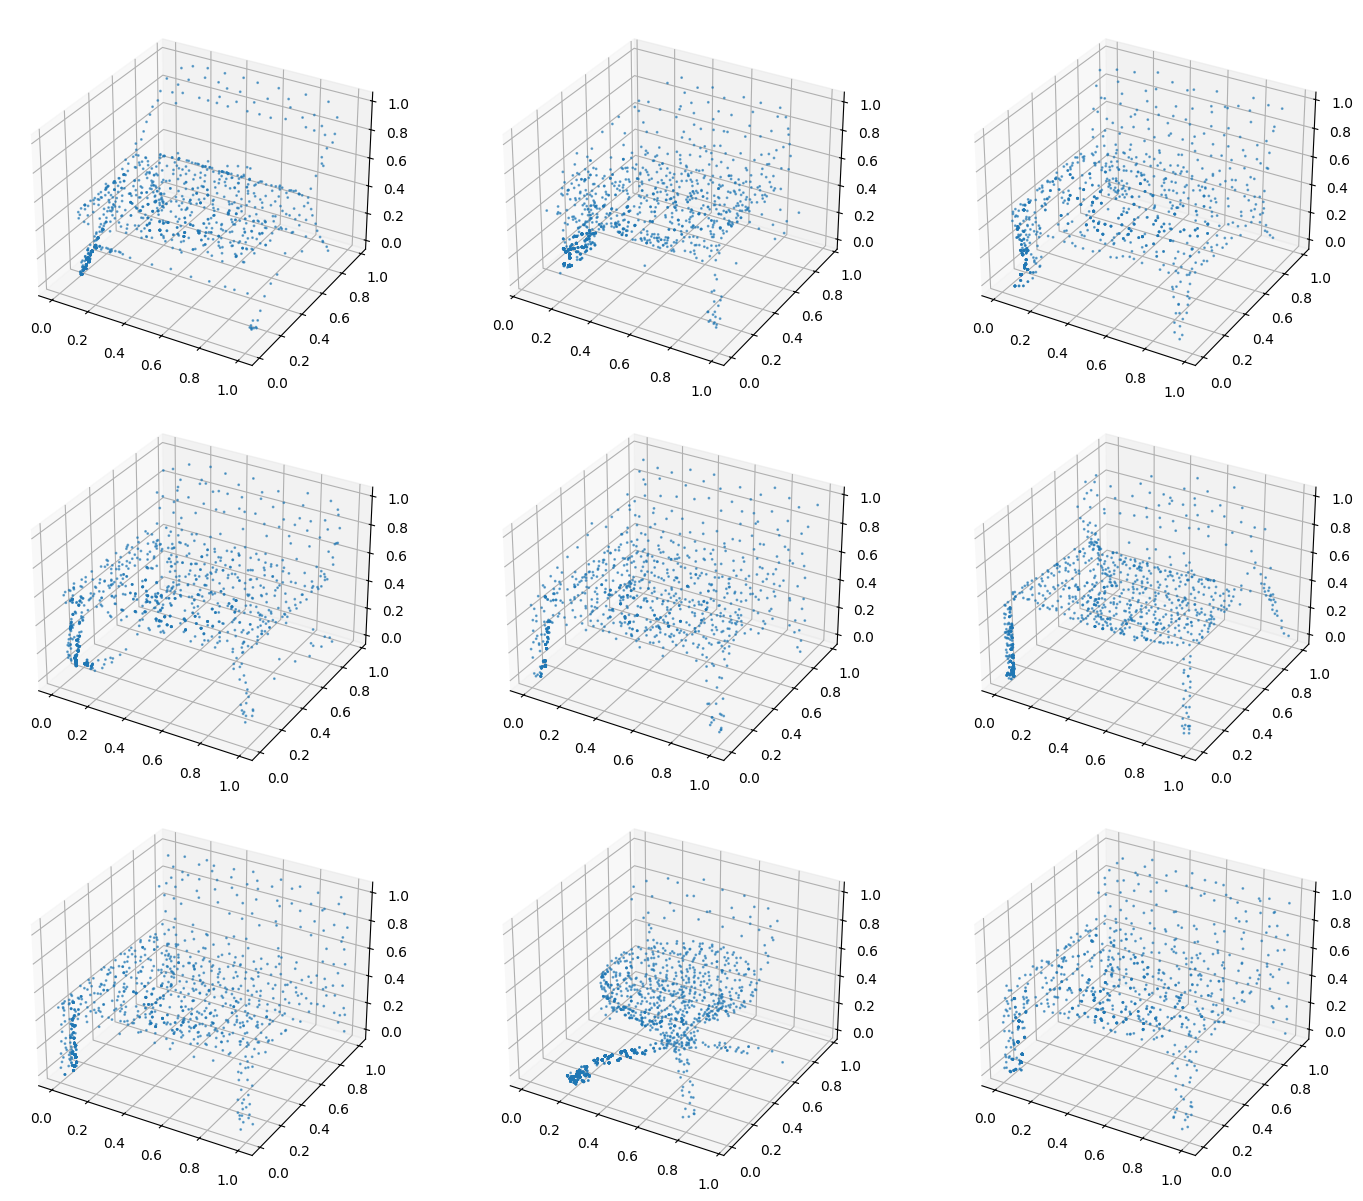

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# z_list_final.npy を読み込んで z_list に変換
z_array = np.load("z_list_final.npy")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
z_list = [torch.tensor(z_array[i], dtype=torch.float32).to(device) for i in range(z_array.shape[0])]

# 可視化用設定
num_points = 2500
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12), subplot_kw={'projection': '3d'})
axes = axes.flatten()

# 再構成と可視化
for index, z in enumerate(z_list):
    if index >= len(axes):
        break  # 9つのプロットで終了

    # 再構築 (z を 1バッチの形に変換して decode)
    recon_batch = vae.decode(z)  # z をバッチの形状に変換
    print(recon_batch.shape)

    # CPU上で detach して numpy に変換
    # デコード結果 recon_batch: (1, num_points, 3)
    reconst_np = recon_batch.squeeze(0).cpu().detach().numpy()  # -> (num_points, 3)

    # 各軸を列インデックスで取得
    reconst_x = reconst_np[:, 0]
    reconst_y = reconst_np[:, 1]
    reconst_z = reconst_np[:, 2]

    # プロット
    axes[index].scatter(reconst_x, reconst_y, reconst_z, s=1, alpha=0.6)

    # 潜在変数の値をフラット化してタイトルに表示
    z_flat = z.view(-1).tolist()  # 1次元化
    z_str = ", ".join([f"{value:.2f}" for value in z_flat])
    #axes[index].set_title(f"Latent Variables: {z_str}")

# 最後にプロットを表示
plt.tight_layout()
plt.show()

# 再構成誤差チェック using CD

Chamfer Distances: [0.017847450450062752, 0.025400716811418533, 0.024920480325818062, 0.028191305696964264, 0.025029102340340614, 0.015964852645993233, 0.0243590846657753, 0.01901911571621895, 0.028129981830716133]
Average Chamfer Distance: 0.02320689894258976


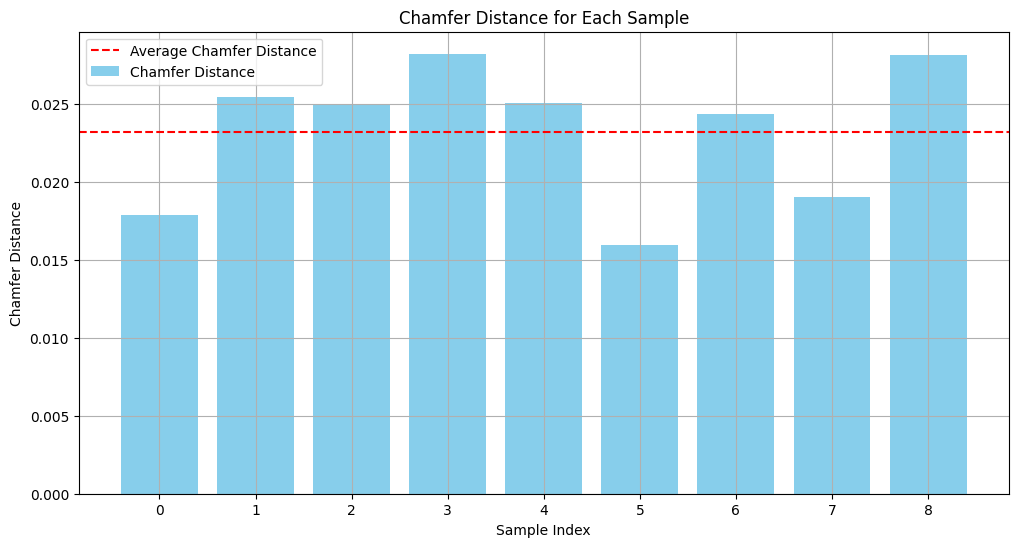

In [9]:
import torch
from torch.utils.data import DataLoader, TensorDataset
reconstructed_point_cloud=[]
# Chamfer Distanceの計算
chamfer_distances = []
for i, (x,) in enumerate(data_loader):
    x = x.to(device)
    x = x.squeeze(0)

    # Decode z_list[i]
    #z = torch.tensor(z_list[i]).to(device)
    recon_batch = vae.decode(z_list[i])
    # CPU上で detach して numpy に変換
    reconst_np = recon_batch.squeeze(0).cpu().detach().numpy()  # -> (num_points, 3)

    # 各軸を列インデックスで取得し、Tensor に変換
    reconst_x = torch.from_numpy(reconst_np[:, 0])
    reconst_y = torch.from_numpy(reconst_np[:, 1])
    reconst_z = torch.from_numpy(reconst_np[:, 2])

    # Tensor を stack して reconstructed_point_cloud を作成
    reconstructed_point_cloud = torch.stack([reconst_x, reconst_y, reconst_z], dim=-1).unsqueeze(0).to(device)

    num_points=2500
    # 元の点群の形状を整える
    original_point_cloud = x.reshape(1, num_points, 3).to(device)

    # カスタム関数でChamfer Distanceを計算
    loss_cd = chamfer_distance(original_point_cloud, reconstructed_point_cloud)
    chamfer_distances.append(loss_cd.item())

# Chamfer距離を出力
print("Chamfer Distances:", chamfer_distances)
average_chamfer_distance = sum(chamfer_distances) / len(chamfer_distances)
print(f"Average Chamfer Distance: {average_chamfer_distance}")

import matplotlib.pyplot as plt

# Chamfer Distancesの棒グラフをプロット
plt.figure(figsize=(12, 6))
plt.bar(range(len(chamfer_distances)), chamfer_distances, color='skyblue', label='Chamfer Distance')
plt.axhline(y=average_chamfer_distance, color='r', linestyle='--', label='Average Chamfer Distance')

# グラフの装飾
plt.title('Chamfer Distance for Each Sample')
plt.xlabel('Sample Index')
plt.ylabel('Chamfer Distance')
plt.xticks(range(len(chamfer_distances)))
plt.legend()
plt.grid(True)
plt.show()

# 再構成誤差チェック using EMD

EMD Distances: [0.6694111041776611, 0.5991799856695558, 0.6901201734393578, 0.6894050234894936, 0.6725272614931495, 0.6601300598087383, 0.7085358764517338, 0.49970371037182576, 0.7616388789933463]
Average EMD Distance: 0.6611835637660958


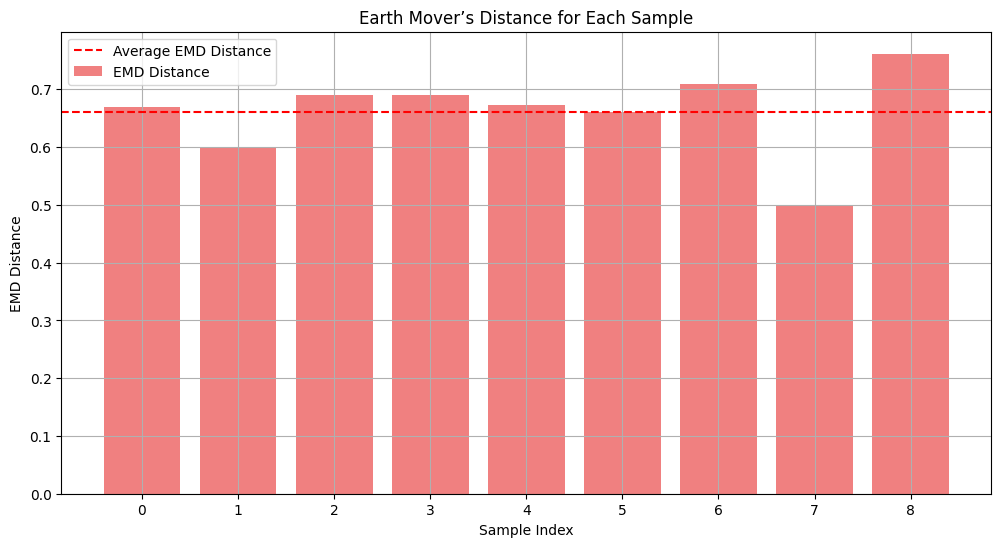

In [10]:
import torch
import ot  # Optimal Transportライブラリ
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# EMDの計算
emd_distances = []
reconstructed_point_cloud=[]
for i, (x,) in enumerate(data_loader):
    x = x.to(device)
    x = x.squeeze(0)

    # Decode z_list[i]
    #z = torch.tensor(z_list[i]).to(device)
    recon_batch = vae.decode(z_list[i])
    # CPU上で detach して numpy に変換
    reconst_np = recon_batch.squeeze(0).cpu().detach().numpy()  # -> (num_points, 3)

    # 各軸を列インデックスで取得し、Tensor に変換
    reconst_x = torch.from_numpy(reconst_np[:, 0])
    reconst_y = torch.from_numpy(reconst_np[:, 1])
    reconst_z = torch.from_numpy(reconst_np[:, 2])

    # Tensor を stack して reconstructed_point_cloud を作成
    reconstructed_point_cloud = torch.stack([reconst_x, reconst_y, reconst_z], dim=-1).unsqueeze(0).to(device)
    reconstructed_point_cloud = reconstructed_point_cloud.reshape(num_points, 3).to(device)


    # 元の点群の形状を整える
    original_point_cloud = x.reshape(num_points, 3).to(device)

    # カスタム関数でEMDを計算
    loss_emd = emd_distance(original_point_cloud, reconstructed_point_cloud)
    emd_distances.append(loss_emd)

# EMDの結果を出力
print("EMD Distances:", emd_distances)
average_emd_distance = sum(emd_distances) / len(emd_distances)
print(f"Average EMD Distance: {average_emd_distance}")

# EMDの棒グラフをプロット
plt.figure(figsize=(12, 6))
plt.bar(range(len(emd_distances)), emd_distances, color='lightcoral', label='EMD Distance')
plt.axhline(y=average_emd_distance, color='r', linestyle='--', label='Average EMD Distance')

# グラフの装飾
plt.title('Earth Mover’s Distance for Each Sample')
plt.xlabel('Sample Index')
plt.ylabel('EMD Distance')
plt.xticks(range(len(emd_distances)))
plt.legend()
plt.grid(True)
plt.show()